In [13]:
!pip install datasets transformers wordcloud scikit-learn


In [14]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch


In [15]:
dataset = load_dataset("ai4bharat/IndicSentenceSummarization", "hi")
df = pd.DataFrame(dataset['train'])

# Reduce dataset to 5000 rows for faster training
df = df.sample(5000, random_state=42)

print(df.head())
print(df.info())
print("\nNull values:\n", df.isnull().sum())
print("\nUnique values:\n", df.nunique())


            id                                              input  \
155029  155030  यूरो के मुकाबले अमेरिकी डॉलर के कमजोर पड़ने और...   
47146    47147  बहुराष्ट्रीय कंपनियों की भारतीय इकाइयों द्वारा...   
78061    78062  बैंकों द्वारा बीमा योजनाएं बेचने से बैंकों को ...   
36251    36252  खबरें आ रही हैं कि भारतीय इस्पात प्राधिकरण (से...   
197904  197905  राफेल सौदे पर नरेंद्र मोदी सरकार के खिलाफ कांग...   

                                                   target  \
155029                            पाम ऑयल में तेजी बरकरार   
47146   कराधान में अनिश्चितता है विदेशी निवेशकों की चिंता   
78061                 बैंक और बीमा योजना में फंसा आम आदमी   
36251                          सेल नहीं देगा इस साल बोनस!   
197904  राफेल सौदे से एचएएल को बाहर करने के लिए यूपीए ...   

                                                      url  
155029                                               None  
47146                                                None  
78061                                 

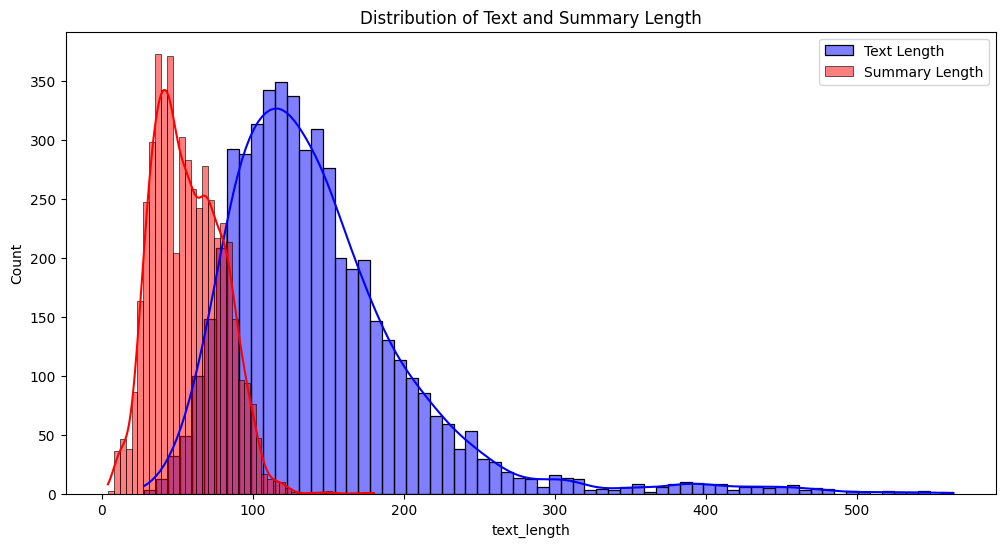

In [16]:
df['text_length'] = df['input'].apply(len)
df['summary_length'] = df['target'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, color="blue", label="Text Length")
sns.histplot(df['summary_length'], kde=True, color="red", label="Summary Length")
plt.legend()
plt.title("Distribution of Text and Summary Length")
plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-lohit-deva is already the newest version (2.95.4-4).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


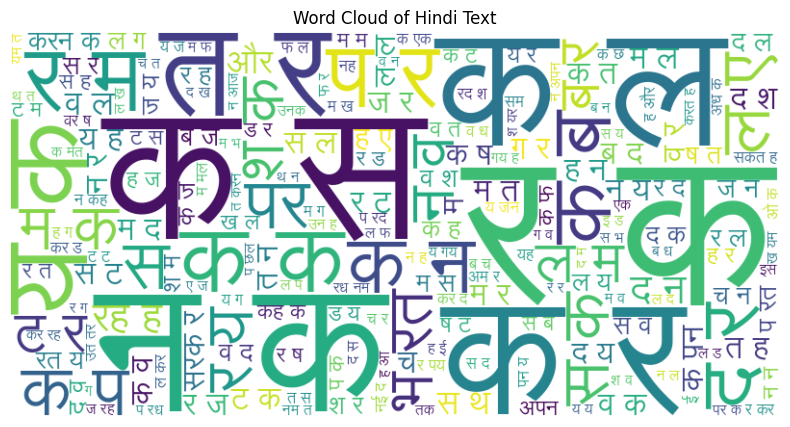

In [17]:
!apt-get install -y fonts-lohit-deva

# Define a proper Devanagari font
font_path = "/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"

# Generate Word Cloud
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(" ".join(df['input']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hindi Text')
plt.show()


In [18]:
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [19]:
def preprocess_function(examples):
    inputs = examples["input"]
    targets = examples["target"]

    # Tokenize inputs (Reduce max_length for faster training)
    model_inputs = tokenizer(
        inputs,
        max_length=96,  # Reduced from 128
        padding="max_length",
        truncation=True
    )

    # Tokenize targets (Reduce max_length for faster training)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=48,  # Reduced from 64
            padding="max_length",
            truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Tokenizing dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/42850 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,  # Reduced from 3 → 2
    per_device_train_batch_size=16,  # Increased from 8 → 16
    per_device_eval_batch_size=16,  # Increased for faster validation
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=500,  # Reduce logging overhead
    report_to="none",  # Disable W&B
    fp16=True,  # Mixed Precision for faster training on GPU
    save_total_limit=1  # Prevent saving too many models
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42).select(range(4000)),  # Reduced from 5000
    eval_dataset=tokenized_dataset["validation"].shuffle(seed=42).select(range(1000)),  # Reduced from 2000
    data_collator=data_collator,
)

trainer.train()


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,10.493402


Epoch,Training Loss,Validation Loss
1,No log,10.493402
2,18.555600,8.373138


TrainOutput(global_step=500, training_loss=18.555640625, metrics={'train_runtime': 14758.3699, 'train_samples_per_second': 0.542, 'train_steps_per_second': 0.034, 'total_flos': 793124536320000.0, 'train_loss': 18.555640625, 'epoch': 2.0})

In [12]:
eval_results = trainer.evaluate()
print(f"Perplexity: {np.exp(eval_results['eval_loss']):.2f}")


Perplexity: 4329.20


In [22]:
def generate_summary(text):
    inputs = tokenizer([text], max_length=512, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=128, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [24]:
sample_text = df['input'].iloc[0]
summary = generate_summary(sample_text)

print("Original Text:", sample_text)
print("Generated Summary:", summary)
print("Original Summary:", df['target'].iloc[0])


Original Text: यूरो के मुकाबले अमेरिकी डॉलर के कमजोर पड़ने और कच्चे तेल की मांग बढ़ने और सोयाबीन तेल के दामों में उछाल का असर मलयेशिया में पाम ऑयल की कीमतों पर भी पड़ा है।
Generated Summary: <extra_id_0> पर भी
Original Summary: पाम ऑयल में तेजी बरकरार


In [25]:
models = [
    "google/mt5-small",
    "t5-small",
    "facebook/bart-base",
    "Helsinki-NLP/opus-mt-hi-en",
    "microsoft/prophetnet-large"
]


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

results = {}

for model_name in models:
    print(f"\nEvaluating {model_name}...\n")

    # Load the correct tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # Retokenize dataset for the current model
    def preprocess_function_model(examples):
        inputs = examples["input"]
        targets = examples["target"]

        # Tokenize inputs
        model_inputs = tokenizer(
            inputs,
            max_length=96,  # Adjust as needed
            padding="max_length",
            truncation=True
        )

        # Tokenize targets
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                targets,
                max_length=48,  # Adjust as needed
                padding="max_length",
                truncation=True
            )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_dataset_model = dataset.map(preprocess_function_model, batched=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset_model["train"].shuffle(seed=42).select(range(4000)),  # Keep dataset size same
        eval_dataset=tokenized_dataset_model["validation"].shuffle(seed=42).select(range(1000)),
    )

    eval_results = trainer.evaluate()
    results[model_name] = np.exp(eval_results['eval_loss'])

    print(f"{model_name} Perplexity: {results[model_name]:.2f}")

# Print final results
print("\nModel Performance Comparison (Lower Perplexity is Better):")
for model, perplexity in results.items():
    print(f"{model}: {perplexity:.2f}")



Evaluating google/mt5-small...



Map:   0%|          | 0/199512 [00:00<?, ? examples/s]

Map:   0%|          | 0/42771 [00:00<?, ? examples/s]

Map:   0%|          | 0/42850 [00:00<?, ? examples/s]

google/mt5-small Perplexity: 98388172243503472.00

Evaluating t5-small...



tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/199512 [00:00<?, ? examples/s]

Map:   0%|          | 0/42771 [00:00<?, ? examples/s]

Map:   0%|          | 0/42850 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


t5-small Perplexity: 332013.11

Evaluating facebook/bart-base...



config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Map:   0%|          | 0/199512 [00:00<?, ? examples/s]

Map:   0%|          | 0/42771 [00:00<?, ? examples/s]

Map:   0%|          | 0/42850 [00:00<?, ? examples/s]

facebook/bart-base Perplexity: 20.27

Evaluating Helsinki-NLP/opus-mt-hi-en...



tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/304M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Map:   0%|          | 0/199512 [00:00<?, ? examples/s]

In [ ]:
print("\nModel Comparison (Lower Perplexity is Better):")
for model, perplexity in results.items():
    print(f"{model}: {perplexity:.2f}")
